In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json

In [2]:
filename = 'data/customBenchmark_kepler_query.json'
file = open(filename)
data = file.read()
data = json.loads(data)

In [3]:
result = {}

for metric in data:
    temp = []
    if metric == 'kepler_container_joules_total':
        for container_metric in data[metric]:
            tmp = [[container_metric['metric']['container_id'], container_metric['metric']['instance'], values[0], values[1]] for values in container_metric['values']]
            tmp_df = pd.DataFrame(tmp, columns =['container_id', 'node', 'time', 'value'])
            temp.append(tmp_df)
    elif metric == 'node_cpu_seconds_total':
        for node_metric in data[metric]:
            if node_metric['metric']['mode'] == "idle":
                continue
            tmp = [[node_metric['metric']['instance'], node_metric['metric']['cpu'], values[0], values[1]] for values in node_metric['values']]
            tmp_df = pd.DataFrame(tmp, columns =['node', 'cpu', 'time', 'value'])
            temp.append(tmp_df)
    elif metric == 'kepler_node_core_joules_total':
        for node_metric in data[metric]:
            tmp = [[node_metric['metric']['instance'], node_metric['metric']['package'], values[0], values[1]] for values in node_metric['values']]
            tmp_df = pd.DataFrame(tmp, columns =['node', 'cpu', 'time', 'value'])
            temp.append(tmp_df)
    else:
        continue
    t = pd.concat(temp)
    t['value'] = t['value'].astype(float)
    result[metric] = t.reset_index(drop = True)

In [6]:
def get_node_dataframe(data):
    energy = data['kepler_container_joules_total']
    energy_agg = energy.groupby(['node', 'time'], as_index=False)['value'].sum()
    cpu_util = data['node_cpu_seconds_total']
    cpu_util_agg = cpu_util.groupby(['node', 'time'], as_index=False)['value'].sum()
    node_power = data['kepler_node_core_joules_total']
    node_power = node_power.groupby(['node', 'time'], as_index=False)['value'].sum()
    
    final = pd.merge(cpu_util_agg, energy_agg, on = ['time', 'node'])
    final.rename(columns={'value_x':'util', 'value_y':'energy'}, inplace=True)
    final.sort_values('time', inplace=True)

    final = pd.merge(final, node_power, on = ['time', 'node'])
    final.rename(columns={'value':'power'}, inplace=True)
    
    return final


In [7]:
node_df = get_node_dataframe(result)

In [55]:
# import model

In [56]:
# m = model.UtilisationPowerModel()
# node_power_models = {}
# for node in final['node'].unique():
#     node_df = final[final['node'] == node]
#     node_df['util'] = node_df['util'].diff()
#     node_df['energy'] = node_df['energy'].diff()
#     node_df['power'] = node_df['power'].diff()
#     node_df.fillna(0, inplace=True)
#     node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
#     max_util = max(node_df['util'])
#     node_df['util'] = node_df['util']/max_util
#     node_power_models[node] = m.get_model(node_df[['util', 'power']])

In [57]:
data = node_df

In [58]:
data.loc[:,'util'] = data['util'].diff()
data.fillna(0, inplace=True)
data = data[(data[['util']] != 0).all(axis=1)]
max_util = max(data['util'])
data.loc[:,'util'] = data.loc[:,'util']/max_util

/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_16046/1306954140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'util'] = data.loc[:,'util']/max_util


In [59]:
data.loc[:,"util"]

4       0.181533
7       0.178549
10      0.187029
14      0.179491
17      0.181062
          ...   
7187    0.027324
7190    0.023555
7194    0.024497
7197    0.025911
7200    0.023241
Name: util, Length: 2160, dtype: float64

In [61]:
data

,node,time,util,energy,power
4,172.19.0.2:9100,1699436712,0.181533,202347.903,560187.288
7,172.19.0.2:9100,1699436721,0.178549,202392.678,560302.758
10,172.19.0.2:9100,1699436730,0.187029,202428.096,560394.099
14,172.19.0.2:9100,1699436742,0.179491,202487.826,560548.161
17,172.19.0.2:9100,1699436751,0.181062,202529.511,560655.657
...,...,...,...,...,...
7187,172.19.0.2:9100,1699458261,0.027324,245354.406,1104962.292
7190,172.19.0.2:9100,1699458270,0.023555,245376.498,1105019.226
7194,172.19.0.2:9100,1699458282,0.024497,245406.747,1105097.130
7197,172.19.0.2:9100,1699458291,0.025911,245429.421,1105155.576


In [62]:
def roundup(i):
    r = int(i/5)
    if r%2 == 0:
        return math.floor(i/10)*10
    else:
        return math.ceil(i/10)*10

In [63]:
hist = {i*10:0 for i in range(11)}
for i in data['util']:
    hist[roundup(i*100)] += 1

In [64]:
hist

{0: 248,
 10: 32,
 20: 805,
 30: 242,
 40: 52,
 50: 322,
 60: 12,
 70: 156,
 80: 104,
 90: 34,
 100: 153}

In [72]:
degree_of_imbalance = sum(hist.values())/len(hist)*1.7
degree_of_imbalance

333.8181818181818

In [73]:
# Find oversampled region
over_sampled_region = []
for i in hist:
    if hist[i] > degree_of_imbalance:
        over_sampled_region.append(i)
over_sampled_region

[20]

In [74]:
def reduce_data(data, size):
    return data.loc[:size]

In [27]:
n_data = node_df[node_df['node']== '10.242.64.5']

In [28]:
n_data[:30]

,node,time,util,energy,power
1,10.242.64.5,1700124000,0.997114,26433.165,81862.668
2,10.242.64.5,1700124005,0.997125,26433.165,81862.668
5,10.242.64.5,1700124010,0.997125,26433.165,81862.668
7,10.242.64.5,1700124015,0.997125,26688.012,82520.109
9,10.242.64.5,1700124020,0.997140,26688.012,82520.109
10,10.242.64.5,1700124025,0.997140,26688.012,82520.109
12,10.242.64.5,1700124030,0.997140,26688.012,82520.109
14,10.242.64.5,1700124035,0.997147,26688.012,82520.109
16,10.242.64.5,1700124040,0.997147,26688.012,82520.109
18,10.242.64.5,1700124045,0.997147,26606.571,83017.962


In [15]:
n_data.sort_values('time', inplace=True)
n_data.reset_index(drop=True, inplace=True)
n_data

/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_44610/1583804627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_data.sort_values('time', inplace=True)


,node,time,util,energy,power
0,10.242.64.5,1700124000,4036887.12,26433.165,81862.668
1,10.242.64.5,1700124005,4036931.57,26433.165,81862.668
2,10.242.64.5,1700124010,4036931.57,26433.165,81862.668
3,10.242.64.5,1700124015,4036931.57,26688.012,82520.109
4,10.242.64.5,1700124020,4036991.82,26688.012,82520.109
...,...,...,...,...,...
1436,10.242.64.5,1700131180,4048560.87,42353.214,171759.366
1437,10.242.64.5,1700131185,4048560.87,42426.669,171948.267
1438,10.242.64.5,1700131190,4048569.97,42426.669,171948.267
1439,10.242.64.5,1700131195,4048569.97,42426.669,171948.267


In [16]:
n_data['util'] = n_data['util'].diff()
n_data['energy'] = n_data['energy'].diff()
n_data['power'] = n_data['power'].diff()
n_data

/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_44610/4236230406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_data['util'] = n_data['util'].diff()
/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_44610/4236230406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_data['energy'] = n_data['energy'].diff()
/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_44610/4236230406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,node,time,util,energy,power
0,10.242.64.5,1700124000,NaN,NaN,NaN
1,10.242.64.5,1700124005,44.45,0.000,0.000
2,10.242.64.5,1700124010,0.00,0.000,0.000
3,10.242.64.5,1700124015,0.00,254.847,657.441
4,10.242.64.5,1700124020,60.25,0.000,0.000
...,...,...,...,...,...
1436,10.242.64.5,1700131180,0.00,0.000,0.000
1437,10.242.64.5,1700131185,0.00,73.455,188.901
1438,10.242.64.5,1700131190,9.10,0.000,0.000
1439,10.242.64.5,1700131195,0.00,0.000,0.000


In [18]:
n_data['power'] = n_data.power.shift(1)

/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_44610/4286008463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_data['power'] = n_data.power.shift(1)


In [23]:
n_data.fillna(0, inplace=True)
n_data = n_data[(n_data[['util']] != 0).all(axis=1)]
n_data = n_data[(n_data[['power']] != 0).all(axis=1)]
max_util = max(n_data['util'])
n_data['util'] = n_data['util']/max_util

/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_44610/293842506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_data.fillna(0, inplace=True)


In [24]:
n_data

,node,time,util,energy,power
4,10.242.64.5,1700124020,0.998178,0.0,657.441
10,10.242.64.5,1700124050,0.728794,0.0,497.853
16,10.242.64.5,1700124080,0.460239,0.0,664.092
22,10.242.64.5,1700124110,0.996687,0.0,636.201
28,10.242.64.5,1700124140,0.704937,0.0,510.084
...,...,...,...,...,...
1414,10.242.64.5,1700131070,0.119781,0.0,182.619
1420,10.242.64.5,1700131100,0.135023,0.0,177.246
1426,10.242.64.5,1700131130,0.140822,0.0,181.080
1432,10.242.64.5,1700131160,0.146952,0.0,182.358


In [25]:
import model

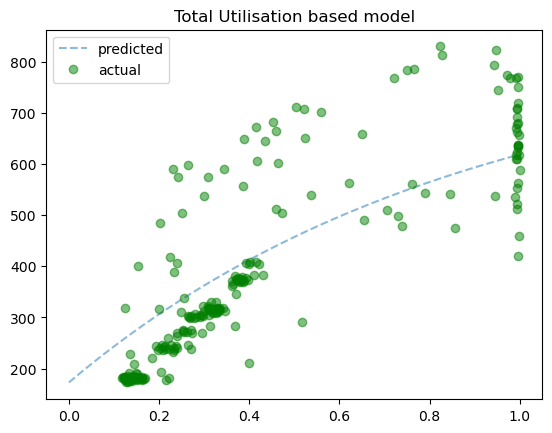

(array([[618.1426 ],
        [542.47473],
        [440.1119 ],
        [617.7842 ],
        [534.5907 ],
        [466.365  ],
        [616.74554],
        [517.2288 ],
        [481.679  ],
        [618.1824 ],
        [278.01917],
        [274.2719 ],
        [265.1106 ],
        [258.05994],
        [264.792  ],
        [270.8145 ],
        [285.43805],
        [278.33032],
        [263.94153],
        [260.6339 ],
        [269.44666],
        [268.28662],
        [319.146  ],
        [412.04056],
        [305.3296 ],
        [346.8781 ],
        [353.28146],
        [357.2959 ],
        [361.01215],
        [360.30652],
        [345.96936],
        [368.35718],
        [393.82635],
        [394.97238],
        [417.5797 ],
        [412.8252 ],
        [408.72888],
        [412.43307],
        [422.43323],
        [419.51257],
        [338.17548],
        [262.55682],
        [269.0251 ],
        [277.81165],
        [286.86896],
        [264.57953],
        [255.58228],
        [263.

In [26]:
m = model.UtilisationPowerModel()
m.get_model(n_data[['util', 'power']])